# Libraries

In [ ]:
import os
os.chdir('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src')  # Provide the new path here

from operator import itemgetter
from tqdm import tqdm
import time
from datetime import datetime
import json
import copy

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import rioxarray
import fiona

import scipy

#import matplotlib
import matplotlib.pyplot as plt

#from rasterio.enums import Resampling

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data.sampler import RandomSampler
import torch.nn as nn
from torch.autograd import Variable

import wandb

import torchview
from torchview import draw_graph

from utils.plot import *
import importlib


from dataloaders import dataset_sparse
from dataloaders.dataset_2d import *
from subprocess import Popen

# Directories

In [2]:
json_file = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/VideoCond/SparseData_Transformer_0.json" #config_files_1d/lstm_att_1.json
config = {}
with open(json_file) as f:
    config = json.load(f)
    print(f"Read data.json: {config}")

Read data.json: {'cuda_device': 'cuda:0', 'entity': 'gsartor-unito', 'experiment_name': 'SparseData_DL', 'run_name': 'SparseData_Transformer', 'comments': None, 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/logs', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/models', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'weather_dtm': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI_arpa_weather.nc', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dataset_type': 'Dataset_Sparse', 'piezo_head': True, 'normalization': True, 'date_max_norm': '2017-12-31', 'all_dataset': True, 'max_ds_elems': N

# Weekly

## Dataset

In [3]:
ds = dataset_sparse.Dataset_Sparse(config)

    Loading weather data... Done!
    Loading dtm... Done!
    Loading underground water data... Done!
    Norm factors:
{'target_mean': np.float64(298.19569411165224), 'target_std': np.float64(73.65282819016456), 'dtm_mean': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(1139.4907, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'dtm_std': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(884.7991, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'lat_mean': np.float64(44.8125), 'lat_std': np.float64(0.3227486121839514), 'lon_mean': np.float64(7.375), 'lon_std': np.float64(0.43150656619183286), 'weather_mean': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    prec         float32 4B 2.602
    tmax         float32 4B 12.35
    tmin         float32 4B 5.037
    tmean        float32 4B 8.694, 'weather_std': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spa

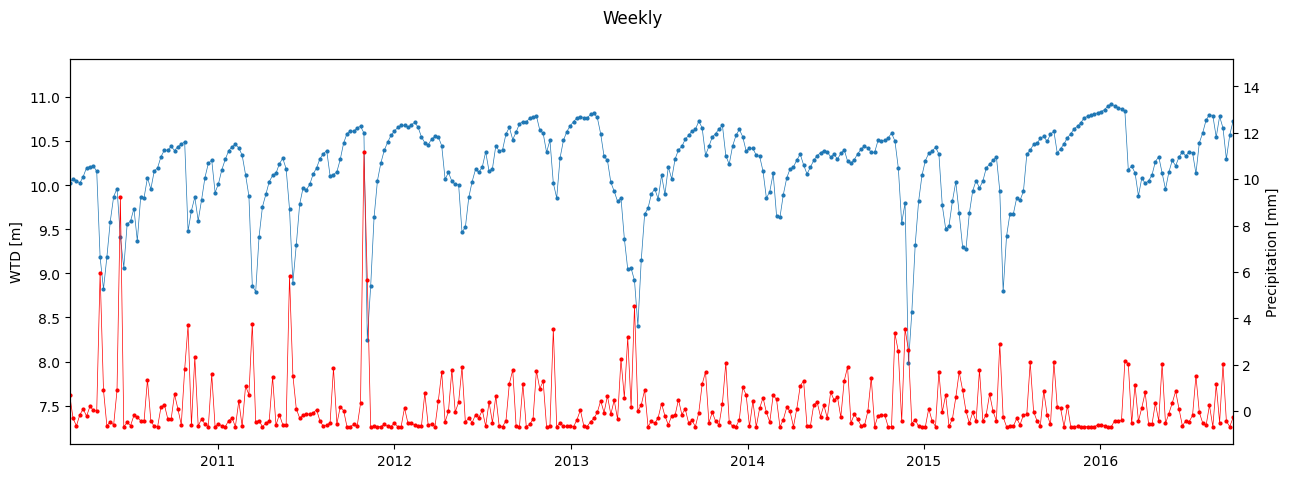

correlaiton -0.29996285212749485


In [22]:
sensor_id = ds.wtd_names.loc[ds.wtd_names["munic"] == "Barge","sensor_id"].values[0]

ts_wtd = ds.wtd_df.loc[pd.IndexSlice[:,sensor_id],"wtd"]

ts_weather = ds.weather_xr.sel(lon = ds.wtd_names.loc[ds.wtd_names["munic"] == "Barge","geometry"].x.values,
                               lat = ds.wtd_names.loc[ds.wtd_names["munic"] == "Barge","geometry"].y.values,
                               time =  ts_wtd.index.get_level_values(0).unique(),
                               method = "nearest").drop_vars("spatial_ref").to_dataframe()

fig, ax = plt.subplots(figsize = (15,5))

fig.suptitle("Weekly")

ax.plot(ts_wtd.index.get_level_values(0).values,
        ts_wtd.values, lw = 0.5, marker = "o", markersize = 2)

ax.set_ylabel("WTD [m]")
ax2 = ax.twinx()

ax2.plot(ts_weather.index.get_level_values(0).values,
         ts_weather["prec"], color = "red", lw = 0.5, marker = "o", markersize = 2)

ax2.set_ylabel("Precipitation [mm]")


ax.set_xlim(np.datetime64("2010-03-01"),
            np.datetime64("2016-10-01"))

plt.show()
corr = scipy.stats.pearsonr(ts_weather.loc[~ts_wtd.isna().values, "prec"].values.flatten(),
                     ts_wtd.loc[~ts_wtd.isna().values].values.flatten())[0]
print("correlaiton", corr)


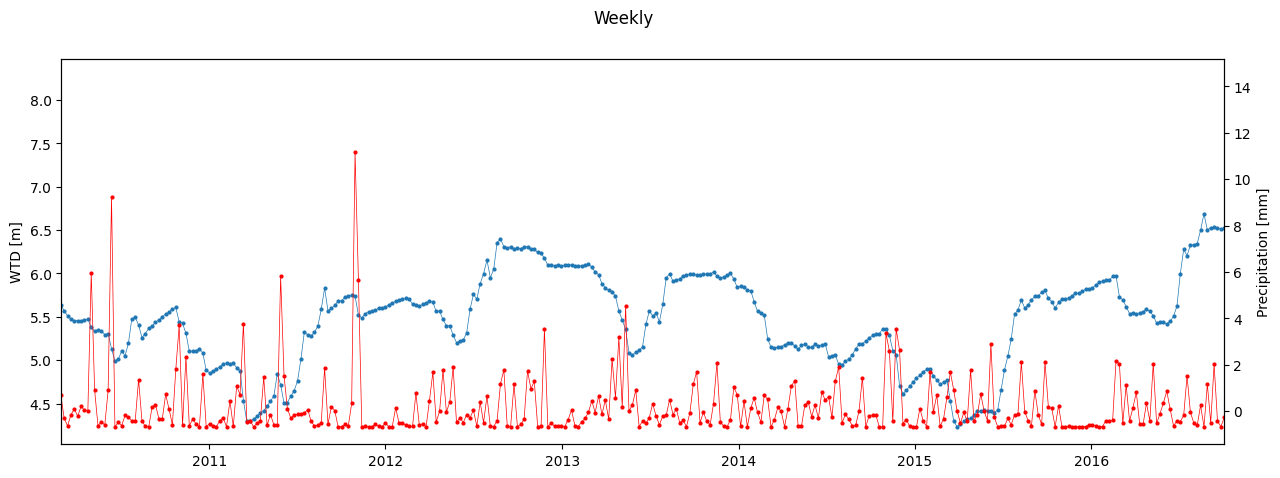

correlaiton -0.04515622550206416


In [21]:
sensor_id = ds.wtd_names.loc[ds.wtd_names["munic"] == "Carmagnola","sensor_id"].values[0]

ts_wtd = ds.wtd_df.loc[pd.IndexSlice[:,sensor_id],"wtd"]
ts_weather = ds.weather_xr.sel(lon = ds.wtd_names.loc[ds.wtd_names["munic"] == "Barge","geometry"].x.values,
                               lat = ds.wtd_names.loc[ds.wtd_names["munic"] == "Barge","geometry"].y.values,
                               time =  ts_wtd.index.get_level_values(0).unique(),
                               method = "nearest").drop_vars("spatial_ref").to_dataframe()

fig, ax = plt.subplots(figsize = (15,5))

fig.suptitle("Weekly")

ax.plot(ts_wtd.index.get_level_values(0).values,
        ts_wtd.values, lw = 0.5, marker = "o", markersize = 2)

ax.set_ylabel("WTD [m]")
ax2 = ax.twinx()

ax2.plot(ts_weather.index.get_level_values(0).values,
         ts_weather["prec"], color = "red", lw = 0.5, marker = "o", markersize = 2)

ax2.set_ylabel("Precipitation [mm]")


ax.set_xlim(np.datetime64("2010-03-01"),
            np.datetime64("2016-10-01"))

plt.show()
corr = scipy.stats.pearsonr(ts_weather.loc[~ts_wtd.isna().values, "prec"].values.flatten(),
                     ts_wtd.loc[~ts_wtd.isna().values].values.flatten())[0]
print("correlaiton", corr)


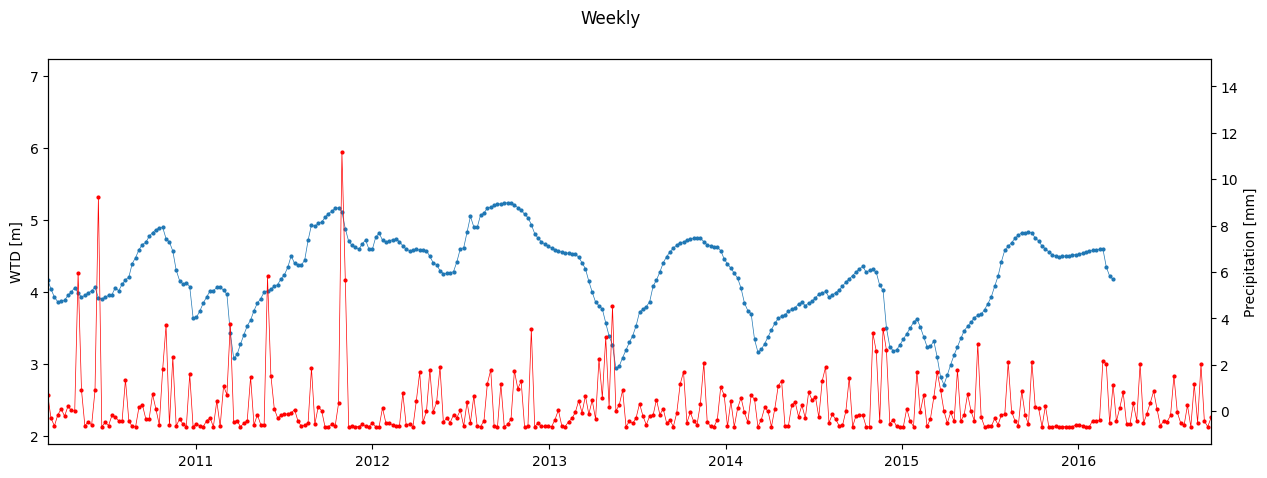

correlaiton -0.052066042062984146


In [20]:
sensor_id = ds.wtd_names.loc[ds.wtd_names["munic"] == "Racconigi","sensor_id"].values[0]

ts_wtd = ds.wtd_df.loc[pd.IndexSlice[:,sensor_id],"wtd"]
ts_weather = ds.weather_xr.sel(lon = ds.wtd_names.loc[ds.wtd_names["munic"] == "Barge","geometry"].x.values,
                               lat = ds.wtd_names.loc[ds.wtd_names["munic"] == "Barge","geometry"].y.values,
                               time =  ts_wtd.index.get_level_values(0).unique(),
                               method = "nearest").drop_vars("spatial_ref").to_dataframe()

fig, ax = plt.subplots(figsize = (15,5))

fig.suptitle("Weekly")

ax.plot(ts_wtd.index.get_level_values(0).values,
        ts_wtd.values, lw = 0.5, marker = "o", markersize = 2)

ax.set_ylabel("WTD [m]")
ax2 = ax.twinx()

ax2.plot(ts_weather.index.get_level_values(0).values,
         ts_weather["prec"], color = "red", lw = 0.5, marker = "o", markersize = 2)

ax2.set_ylabel("Precipitation [mm]")


ax.set_xlim(np.datetime64("2010-03-01"),
            np.datetime64("2016-10-01"))

plt.show()
corr = scipy.stats.pearsonr(ts_weather.loc[~ts_wtd.isna().values, "prec"].values.flatten(),
                     ts_wtd.loc[~ts_wtd.isna().values].values.flatten())[0]
print("correlaiton", corr)

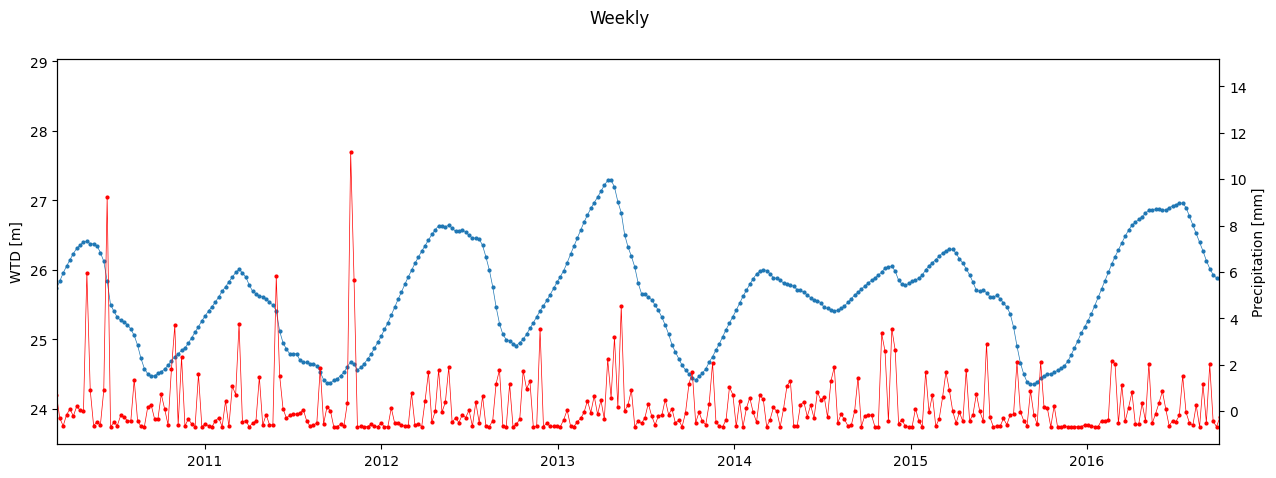

correlaiton 0.01884577362814844


In [19]:
sensor_id = ds.wtd_names.loc[ds.wtd_names["munic"] == "Collegno","sensor_id"].values[0]

ts_wtd = ds.wtd_df.loc[pd.IndexSlice[:,sensor_id],"wtd"]
ts_weather = ds.weather_xr.sel(lon = ds.wtd_names.loc[ds.wtd_names["munic"] == "Barge","geometry"].x.values,
                               lat = ds.wtd_names.loc[ds.wtd_names["munic"] == "Barge","geometry"].y.values,
                               time =  ts_wtd.index.get_level_values(0).unique(),
                               method = "nearest").drop_vars("spatial_ref").to_dataframe()

fig, ax = plt.subplots(figsize = (15,5))

fig.suptitle("Weekly")

ax.plot(ts_wtd.index.get_level_values(0).values,
        ts_wtd.values, lw = 0.5, marker = "o", markersize = 2)

ax.set_ylabel("WTD [m]")
ax2 = ax.twinx()

ax2.plot(ts_weather.index.get_level_values(0).values,
         ts_weather["prec"], color = "red", lw = 0.5, marker = "o", markersize = 2)

ax2.set_ylabel("Precipitation [mm]")


ax.set_xlim(np.datetime64("2010-03-01"),
            np.datetime64("2016-10-01"))

plt.show()
corr = scipy.stats.pearsonr(ts_weather.loc[~ts_wtd.isna().values, "prec"].values.flatten(),
                     ts_wtd.loc[~ts_wtd.isna().values].values.flatten())[0]
print("correlaiton", corr)

# Daily

In [23]:
config["frequency"] = "D"

In [24]:
dds = dataset_sparse.Dataset_Sparse(config)

    Loading weather data... Done!
    Loading dtm... Done!
    Loading underground water data... Done!
    Norm factors:
{'target_mean': np.float64(298.52160000576254), 'target_std': np.float64(74.07745590089483), 'dtm_mean': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(1139.4907, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'dtm_std': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(884.7991, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'lat_mean': np.float64(44.8125), 'lat_std': np.float64(0.3227486121839514), 'lon_mean': np.float64(7.375), 'lon_std': np.float64(0.43150656619183286), 'weather_mean': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    prec         float32 4B 2.601
    tmax         float32 4B 12.35
    tmin         float32 4B 5.036
    tmean        float32 4B 8.693, 'weather_std': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spa

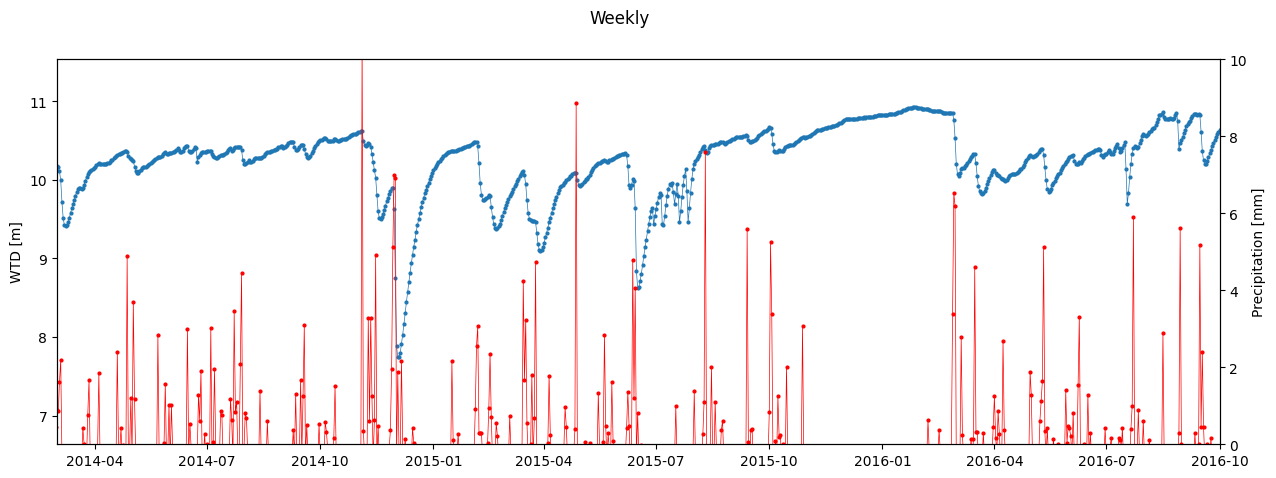

correlaiton -0.09137434918395466


In [29]:
sensor_id = dds.wtd_names.loc[dds.wtd_names["munic"] == "Barge","sensor_id"].values[0]

ts_wtd = dds.wtd_df.loc[pd.IndexSlice[:,sensor_id],"wtd"]

ts_weather = dds.weather_xr.sel(lon = dds.wtd_names.loc[dds.wtd_names["munic"] == "Barge","geometry"].x.values,
                               lat = dds.wtd_names.loc[dds.wtd_names["munic"] == "Barge","geometry"].y.values,
                               time =  ts_wtd.index.get_level_values(0).unique(),
                               method = "nearest").drop_vars("spatial_ref").to_dataframe()

fig, ax = plt.subplots(figsize = (15,5))

fig.suptitle("Weekly")

ax.plot(ts_wtd.index.get_level_values(0).values,
        ts_wtd.values, lw = 0.5, marker = "o", markersize = 2)

ax.set_ylabel("WTD [m]")
ax2 = ax.twinx()

ax2.plot(ts_weather.index.get_level_values(0).values,
         ts_weather["prec"], color = "red", lw = 0.5, marker = "o", markersize = 2)

ax2.set_ylabel("Precipitation [mm]")


ax.set_xlim(np.datetime64("2014-03-01"),
            np.datetime64("2016-10-01"))

ax2.set_ylim(0, 10)

plt.show()
corr = scipy.stats.pearsonr(ts_weather.loc[~ts_wtd.isna().values, "prec"].values.flatten(),
                     ts_wtd.loc[~ts_wtd.isna().values].values.flatten())[0]
print("correlaiton", corr)

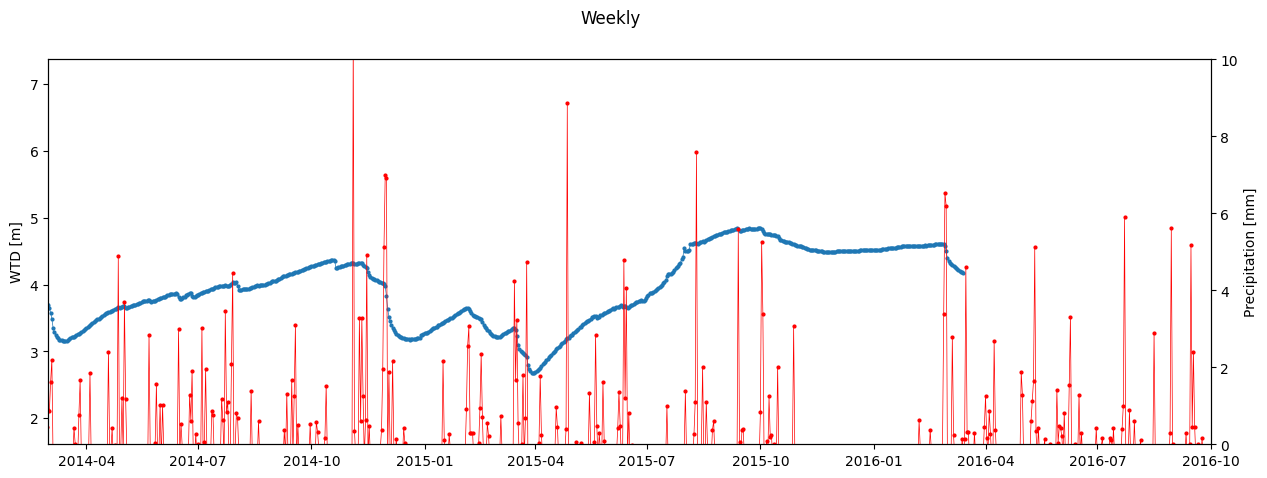

correlaiton -0.019129054969629192


In [30]:
sensor_id = dds.wtd_names.loc[dds.wtd_names["munic"] == "Racconigi","sensor_id"].values[0]

ts_wtd = dds.wtd_df.loc[pd.IndexSlice[:,sensor_id],"wtd"]

ts_weather = dds.weather_xr.sel(lon = dds.wtd_names.loc[dds.wtd_names["munic"] == "Barge","geometry"].x.values,
                               lat = dds.wtd_names.loc[dds.wtd_names["munic"] == "Barge","geometry"].y.values,
                               time =  ts_wtd.index.get_level_values(0).unique(),
                               method = "nearest").drop_vars("spatial_ref").to_dataframe()

fig, ax = plt.subplots(figsize = (15,5))

fig.suptitle("Weekly")

ax.plot(ts_wtd.index.get_level_values(0).values,
        ts_wtd.values, lw = 0.5, marker = "o", markersize = 2)

ax.set_ylabel("WTD [m]")
ax2 = ax.twinx()

ax2.plot(ts_weather.index.get_level_values(0).values,
         ts_weather["prec"], color = "red", lw = 0.5, marker = "o", markersize = 2)

ax2.set_ylabel("Precipitation [mm]")


ax.set_xlim(np.datetime64("2014-03-01"),
            np.datetime64("2016-10-01"))

ax2.set_ylim(0, 10)

plt.show()
corr = scipy.stats.pearsonr(ts_weather.loc[~ts_wtd.isna().values, "prec"].values.flatten(),
                     ts_wtd.loc[~ts_wtd.isna().values].values.flatten())[0]
print("correlaiton", corr)

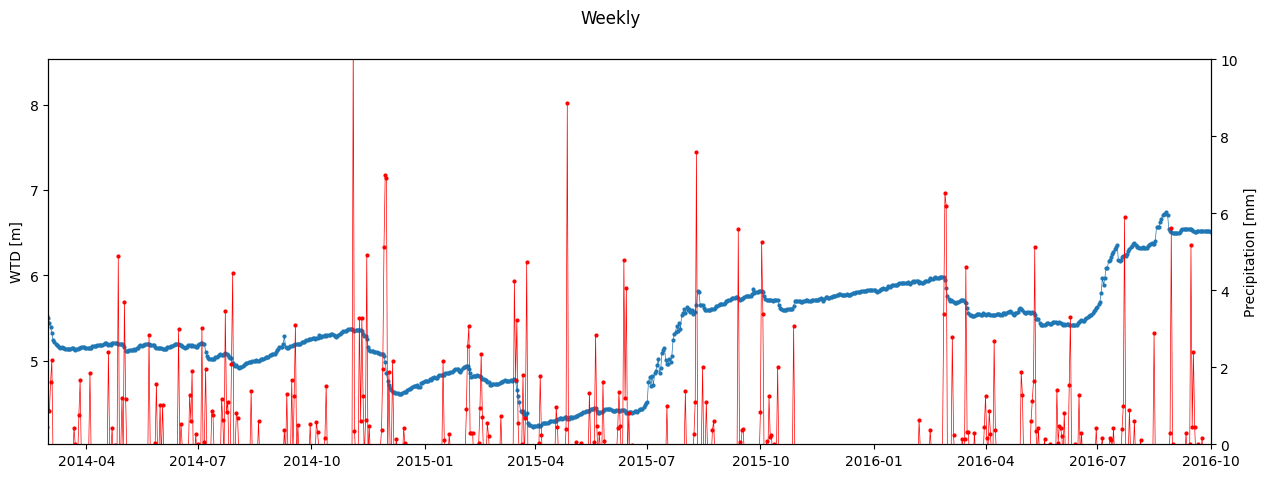

correlaiton -0.017592301565868915


In [31]:
sensor_id = dds.wtd_names.loc[dds.wtd_names["munic"] == "Carmagnola","sensor_id"].values[0]

ts_wtd = dds.wtd_df.loc[pd.IndexSlice[:,sensor_id],"wtd"]

ts_weather = dds.weather_xr.sel(lon = dds.wtd_names.loc[dds.wtd_names["munic"] == "Barge","geometry"].x.values,
                               lat = dds.wtd_names.loc[dds.wtd_names["munic"] == "Barge","geometry"].y.values,
                               time =  ts_wtd.index.get_level_values(0).unique(),
                               method = "nearest").drop_vars("spatial_ref").to_dataframe()

fig, ax = plt.subplots(figsize = (15,5))

fig.suptitle("Weekly")

ax.plot(ts_wtd.index.get_level_values(0).values,
        ts_wtd.values, lw = 0.5, marker = "o", markersize = 2)

ax.set_ylabel("WTD [m]")
ax2 = ax.twinx()

ax2.plot(ts_weather.index.get_level_values(0).values,
         ts_weather["prec"], color = "red", lw = 0.5, marker = "o", markersize = 2)

ax2.set_ylabel("Precipitation [mm]")


ax.set_xlim(np.datetime64("2014-03-01"),
            np.datetime64("2016-10-01"))

ax2.set_ylim(0, 10)

plt.show()
corr = scipy.stats.pearsonr(ts_weather.loc[~ts_wtd.isna().values, "prec"].values.flatten(),
                     ts_wtd.loc[~ts_wtd.isna().values].values.flatten())[0]
print("correlaiton", corr)

In [33]:
from st_moe_pytorch import MoE
from st_moe_pytorch import SparseMoEBlock

In [34]:
moe = MoE(
    dim = 16,
    num_experts = 4,               # increase the experts (# parameters) of your model without increasing computation
    gating_top_n = 2,               # default to top 2 gating, but can also be more (3 was tested in the paper with a lower threshold)
    threshold_train = 0.2,          # at what threshold to accept a token to be routed to second expert and beyond - 0.2 was optimal for 2 expert routing, and apparently should be lower for 3
    threshold_eval = 0.2,
    capacity_factor_train = 1.25,   # experts have fixed capacity per batch. we need some extra capacity in case gating is not perfectly balanced.
    capacity_factor_eval = 2.,      # capacity_factor_* should be set to a value >=1
    balance_loss_coef = 1e-2,       # multiplier on the auxiliary expert balancing auxiliary loss
    router_z_loss_coef = 1e-3,      # loss weight for router z-loss
)

inputs = torch.randn(4, 20, 16)
out, total_aux_loss, balance_loss, router_z_loss = moe(inputs) # (4, 1024, 512), (1,), (1,), (1,)

# for the entire mixture of experts block, in context of transformer

In [40]:
from st_moe_pytorch import SparseMoEBlock

moe_block = SparseMoEBlock(
    moe,
    add_ff_before = False,
    add_ff_after = False
)

out, total_aux_loss, balance_loss, router_z_loss = moe_block(inputs) 

In [43]:
total_aux_loss

tensor(0.0113, grad_fn=<AddBackward0>)

In [41]:
print("Total number of trainable parameters: " ,sum(p.numel() for p in moe_block.parameters() if p.requires_grad))

Total number of trainable parameters:  8712


In [44]:
from models import models_2D

In [51]:
model = models_2D.SparseData_Transformer_STMoE(weather_CHW_dim = [7, 9, 12],
                target_dim = [14, 31],
                spatial_embedding_dim = 16,
                spatial_heads = 2,
                fusion_embedding_dim = 256,
                st_heads = 4,
                st_mha_blocks = 2,
                num_experts = 16,
                densification_dropout = 0.45,
                spatial_dropout = 0.2, # TODO
                layernorm_affine = True,
                activation = "GELU")

In [52]:
print("Total number of trainable parameters: " ,sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters:  19507321


In [56]:
torch.tensor([total_aux_loss, total_aux_loss, total_aux_loss]).sum()

tensor(0.0340)